# Seminars in speech and language processing
## Project: adversarial attacks on speech recognition systems

**Benjamin Maudet, Dorin Doncenco**

---

This project is inspired by [this paper](https://arxiv.org/pdf/1801.01944.pdf). Here, the authors attack the DeepSpeech model. We take inspiration from their method but making our own implementation of the optimization.

## Imports

In [20]:
%pip install jiwer

Note: you may need to restart the kernel to use updated packages.


In [21]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch
# libary to read audio in torch
import torchaudio
from torch.nn import CTCLoss
from jiwer import wer
import soundfile as sf
import numpy as np
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

softmax = torch.nn.LogSoftmax(dim=1)
ctcloss = CTCLoss()

## Loading models and data

In [22]:
# load model and processor
processor_large = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model_large = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
processor_base = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model_base = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# load dummy dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")

In [24]:
samples = [ds[i]["audio"]["array"] for i in range(4)]
truetext = [ds[i]["text"] for i in range(4)]
rates = [ds[i]["audio"]["sampling_rate"] for i in range(4)]

In [25]:
for i in range(4):
    print(truetext[i])
    IPython.display.display(IPython.display.Audio(data=samples[i], rate=rates[i]))
    torchaudio.save(f"sample_{i}.wav", torch.tensor([samples[i]]), rates[i])

BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE


HE HAS GONE AND GONE FOR GOOD ANSWERED POLYCHROME WHO HAD MANAGED TO SQUEEZE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST


I HAVE REMAINED A PRISONER ONLY BECAUSE I WISHED TO BE ONE AND WITH THIS HE STEPPED FORWARD AND BURST THE STOUT CHAINS AS EASILY AS IF THEY HAD BEEN THREADS


THE LITTLE GIRL HAD BEEN ASLEEP BUT SHE HEARD THE RAPS AND OPENED THE DOOR


## The attack !

An adversarial attack is conceptually quite simple: find a perturbation to add to the input of a model to make it predict something else than its intended target, such that the perturbation is as small as possible. The overall problem can be seen as:

$$
min_\delta |\delta|^2_2 + \mathcal{L}(\mathcal{M}(x + \delta), y_a)
$$

where $\mathcal{M}$ is the model to attack, $\mathcal{L}$ is the loss, $x$ is the input, $y_a$ the adversarial target, and $\delta$ the adversarial perturbation.

In the paper mentionned previously, they perform gradient descent on the loss with respect to delta to update it. In their implementation (https://github.com/carlini/audio_adversarial_examples/blob/master/attack.py), the process is as follow (or parameter l2penalty = infinity, which is the default):
- adv_input = input + delta*scaling_factor
- Gradient descent on the CTC loss with respect to the perturbation
- Once a perturbation that perfectly predicts $y_a$ is found, decrease a scaling factor, and start again
- Stop after a certain number of iterations

This is a simple method and computationally efficient, but it feels a bit far from the original formulation. We reimplemented the attack in a way that is closer to the original formulation, and made some additions. In our implementation, we minimize the following custom loss:
$$
\mathcal{L} = \alpha |\delta|_2 + \beta \mathcal{C}(\mathcal{M}(x + \delta), y_a)
$$
    
where $\mathcal{C}$ is the CTC loss, $\alpha$ controls the importance of the perturbation size, and $\beta$ controls the importance of the CTC loss (added for flexibility, even though in tests, $\beta$ is 1 and never changes). This looks just a re-statement of the general problem, however we implement the following additions:
1. In a first phase, $\alpha$ is set to 0, which means we only minimize the CTC loss. This allows us to find a perturbation that perfectly predicts $y_a$ without taking into account the perturbation size, making the start of the optimization easier.
2. When we manage to perfectly predict $y_a$ for the first time, we enter the second phase. At this point, we start changing parameters to shift the focus of the problem to minimizing the perturbation size.
    - $\alpha$ is set to 0.1
    - As long as we continue to perfectly predict $y_a$:
        - $\alpha = \min(1.5, \alpha * 1.05)$
        - $\eta = \text{maprange}(|\delta|_2, \text{start\_norm}, \text{target\_norm}, 0.01, 0.0001)$
            - (maprange linearly maps a value from one range to another)
            - (start_norm is the norm of the perturbation at the start of the second phase, target_norm is the norm we want to reach)
            - ($\eta$ is the learning rate of the gradient descent)
    - When we lose the ability to perfectly predict $y_a$:
        - $\alpha = \max(0.1, \alpha * 0.95)$
3. The above update rules have the following intuition:
    - In phase 1, we found a good alignment between the input and the target, and managed to find a perturbation that perfectly predicts $y_a$. We now want to minimize the perturbation size, and keep the alignment we found.
    - $\alpha$ gets exponentially closer to 1.5 as long as we manage to keep the alignment.
    - If we lose the alignment, we make $\alpha$ jump back a bit, until the alignment is found again.
    - $\eta$, the learning rate of the optimization, is proportional to the size of the perturbation. When the perturbation is large, we can go down quickly as its fairly easy to reduce it. The smaller the perturbation, the harder it is to reduce it, so we reduce the learning rate to make more precise steps.

Finally, we are going to test if we can generate an adversarial example that works on multiple models. We will use the wav2vec2-base model, and the wave2vec2-large model, and optimize the perturbation to work on both, then see if it can generalize to a third. The implementation is exactly the same, except take the sum of the CTC losses of the two models as $\mathcal{C}$. This can therefore be extended to any number of models.

In [26]:
def process_audio(data, rate, processor):
    return processor(data, return_tensors="pt", padding="longest", sampling_rate=rate).input_values

In [27]:
def evaluate(audio, noise, rate, model, processor, device="cuda"):
    processed_audio = process_audio(audio, rate, processor).to(device)
    test = processed_audio + noise.to(device)
    logits = model(test).logits
    print(processor.batch_decode(torch.argmax(logits, dim=-1)))
    return test

In [28]:
def ctc_loss(logits, targets):
    #this function only tested for batch_size = 1
    input_lengths = torch.tensor([logits.shape[0]])
    target_lengths = torch.tensor([targets.shape[0]])
    return ctcloss(logits, targets, input_lengths, target_lengths)

In [29]:
def loss_function(audios, noise, target_logits, modellist, reg_weight, ctc_weight, eps):
    """ 
    Computes the loss of the audio with the current noise added, with a factor to control the size of the noise (via regularization) to allow for backpropagation of the input audio signal.
    audio: original audio after processing (for now)
    noise: noise to be added to the audio
    target_logits: target logits for the sentence we want to generate an attack for
    model: model to be attacked
    reg_weight: weight for the noise regularization term
    ctc_weight: weight for the ctc loss
    eps: maximum perturbation allowed
    """
    N_models = len(modellist)
    audios_perturbed = [a + noise for a in audios]
    #compute dB_x
    dB_x = [(20 * torch.log10(audio-audio.min())).max() for audio in audios]
    #compute dB_delta
    dB_delta = (20 * torch.log10(noise-noise.min())).max()
    #compute dB_x_delta
    dB_x_delta = [dB_delta - dbx for dbx in dB_x]
    #compute logits
    logits = [modellist[i](audios_perturbed[i]).logits for i in range(N_models)]
    logits = [softmax(logits[i][0]).unsqueeze(1) for i in range(N_models)]

    #compute ctc loss
    ctc_loss_values = [ctc_loss(logits[i], target_logits[i]) for i in range(N_models)]
    ctc_loss_value = sum(ctc_loss_values)
    
    meandb = sum(dB_x_delta)/len(dB_x_delta)
    #compute noise regularization
    noise_reg = torch.norm(noise, p=2)
    #compute total loss
    loss = reg_weight * noise_reg + ctc_weight * ctc_loss_value
    if meandb < eps:
        return loss, ctc_loss_value.item(), noise_reg.item(), meandb.item()
    else:
        print(loss.item(), ctc_loss_value.item(), noise_reg.item(), meandb.item())
        return None, None, None, None


In [30]:
def maprange(x, a, b, c, d):
    return c + (x-a)*(d-c)/(b-a)

In [31]:
def attack(target_text, modellist, processorlist, audio, rate, device, initial_lr=0.05, initial_dn_w=0, noise_norm_target=3.5, max_iter=4000):
    N_models = len(modellist)
    target = target_text.replace(" ", "|")
    # target is one sentence
    target = [c for c in target]
    target_token_ids = []
    for p in processorlist:
        t = p.tokenizer.convert_tokens_to_ids(target)
        t = torch.tensor(t).to(device)
        target_token_ids.append(t)
    for m in modellist:
        m.to(device)
    audios = []
    for p in processorlist:
        audios.append(process_audio(audio, rate, p).to(device))
    
    noise = torch.zeros_like(audios[0])
    noise.requires_grad = True

    lr = initial_lr
    optimizer = torch.optim.Adam([noise], lr=lr)
    dn_w = initial_dn_w
    ctc_w = 1.0
    losses = []
    min_norm = float("inf")
    min_db = None
    min_noise = noise

    fh_norm = None
    
    i = 1
    hashit = False
    while True:
        
        if i >= max_iter:
            print("===============================")
            print("!!!! MAX ITERATION REACHED, DIDN'T HIT TRESHOLD !!!!")
            print("Reverting to previous best noise...")
            print("Final noise norm:", min_norm)
            print("Final dB:", min_db)
            print("Sadly exiting...")
            return min_noise, losses
                    
        optimizer.zero_grad()
        loss, ctc_loss_value, deltanorm, dB_x_delta = loss_function(audios, noise, target_token_ids, modellist, dn_w, ctc_w, 10)
        if loss is None:
            print("Maximum noise level reached, what the absolute hell happened?? Exiting.")
            break
        loss.backward()
        optimizer.step()
        itemized_loss = loss.item()
        losses_to_observe = [round(itemized_loss,2), round(ctc_loss_value,2), round(deltanorm,2), round(dB_x_delta,2)]
        losses.append(losses_to_observe)
            
        if i % 10 == 0:
            IPython.display.clear_output(wait=True)
            print()
            print("Iteration: ", i)
            print("  Overall loss: ", round(itemized_loss,2))
            print("  CTC loss: ", round(ctc_loss_value,2))
            print("  Noise norm: ", round(deltanorm,2))
            print("  dB_x_delta: ", round(dB_x_delta,2))
            print(f"  dn_w: {dn_w}, ctc_weight: {ctc_w}, lr: {optimizer.param_groups[0]['lr']}")
            tests = [a + noise for a in audios]
            #logits = model(test).logits
            logits = [modellist[i](tests[i]).logits for i in range(N_models)]
            #predicted_sentence = processor.batch_decode(torch.argmax(logits, dim=-1))[0]
            predicted_sentences = [
                processorlist[i].batch_decode(torch.argmax(logits[i], dim=-1))[0]
                for i in range(N_models)
            ]
            print("  Current predictions:")
            for ps in predicted_sentences:
                print("    " + ps)

            if all(ps == target_text for ps in predicted_sentences):
                if deltanorm < min_norm:
                    min_norm = deltanorm
                    min_db = dB_x_delta
                    min_noise = noise
                    
                if not hashit:
                    print("===============================")
                    print("  !!!! FIRST HIT !!!!")
                    print("===============================")
                    hashit = True
                    print("  Adjusting objective...")
                    dn_w = 0.1
                    ctc_weight = 1
                    fh_norm = deltanorm
                    #optimizer.param_groups[0]["lr"] = 0.005
                else:
                    dn_w = min(1.5, dn_w * 1.05)
                    optimizer.param_groups[0]["lr"] = maprange(deltanorm, fh_norm, noise_norm_target, 0.01, 0.0001)

                if deltanorm < noise_norm_target:
                    print("===============================")
                    print("  !!!! DESIRED NOISE NORM REACHED !!!!")
                    print("  Final noise norm:", deltanorm)
                    print("  Final dB:", dB_x_delta)
                    print("  Happily exiting...")
                    return noise, losses

            elif hashit:
                dn_w = max(0.1, dn_w * 0.95)
                
        i += 1
        

## Generating some adversarial samples

In [32]:
def plotlosses(losses):
    plt.figure(figsize=(30, 5))
    losses = np.array(losses)
    plt.subplot(1, 4, 1)
    plt.plot(losses[:,0])
    plt.title("Overall loss")
    plt.subplot(1, 4, 2)
    plt.plot(losses[:,1])
    plt.title("CTC loss")
    plt.subplot(1, 4, 3)
    plt.plot(losses[:,2])
    plt.title("Noise norm")
    plt.subplot(1, 4, 4)
    plt.plot(losses[:,3])
    plt.title("dB_x_delta")
    plt.show()

For each example we generate, we show:
- The normal prediction of the model
- The actual sentence spoken
- The result of the optimization
- The prediction of the model on the adversarial example
- The perturbed audio (can be played)
- Graphs of
    - The custom loss
    - The CTC loss
    - The perturbation size (noise norm)
    - A measure of maximum loudness of the perturbation in dB

In [33]:
sampleid = 0
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_base, processor_base, "cpu")
truetext[sampleid]

['BECAUSE YOU ARE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BAW WHILE POOR SHAGGY SITS THERE A COOING DOVE']


'BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE'


Iteration:  3690
  Overall loss:  5.42
  CTC loss:  0.17
  Noise norm:  3.5
  dB_x_delta:  -30.55
  dn_w: 1.5, ctc_weight: 1.0, lr: 0.00010042454171503568
  Current predictions:
    I LOVE SEMINARS IN SPEECH AND LANGUAGE PROCESSING
  !!!! DESIRED NOISE NORM REACHED !!!!
  Final noise norm: 3.4957966804504395
  Final dB: -30.55451202392578
  Happily exiting...

Final prediction :
['I LOVE SEMINARS IN SPEECH AND LANGUAGE PROCESSING']


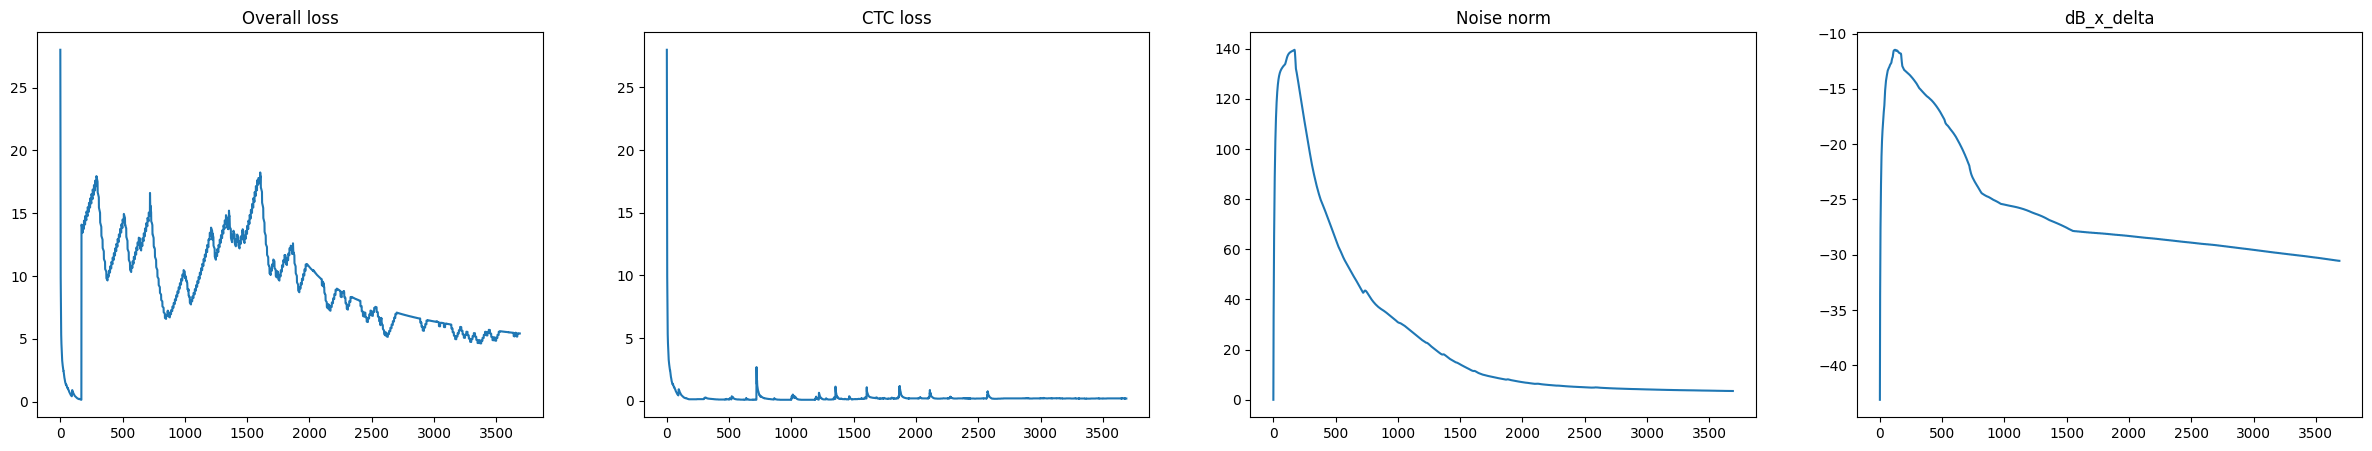

In [34]:
finalnoise, losses = attack(
    "I LOVE SEMINARS IN SPEECH AND LANGUAGE PROCESSING",
    [model_base],
    [processor_base],
    samples[sampleid],
    rates[sampleid],
    "cuda",
    noise_norm_target=3.5
)
print()
print("Final prediction :")
finalnoise = finalnoise.detach()
attacked_audio = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_base, processor_base).cpu()
IPython.display.display(IPython.display.Audio(attacked_audio, rate=rates[sampleid]))
torchaudio.save(f"sample_{sampleid}_attack.wav", attacked_audio, rates[sampleid])
plotlosses(losses)

In [35]:
sampleid = 1
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_base, processor_base)
truetext[sampleid]

['HE HAS GONE AND GONE FOR GOOD ANSWERED POLYCHROME WHO HAD MANAGED TO SQUEEZE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST']


'HE HAS GONE AND GONE FOR GOOD ANSWERED POLYCHROME WHO HAD MANAGED TO SQUEEZE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST'


Iteration:  3990
  Overall loss:  1.46
  CTC loss:  0.05
  Noise norm:  4.45
  dB_x_delta:  -34.52
  dn_w: 0.3160763612141416, ctc_weight: 1.0, lr: 0.00016503923729209793
  Current predictions:
    STOP RIGHT THERE CRIMINAL SCUM YOU HAVE VIOLATED THE LAW PY THE COURT A FINE OR SERVE YOUR SENTENCE
!!!! MAX ITERATION REACHED, DIDN'T HIT TRESHOLD !!!!
Reverting to previous best noise...
Final noise norm: 4.483922481536865
Final dB: -34.3441276550293
Sadly exiting...

Final prediction :
['STOP RIGHT THERE CRIMINAL SCUM YOU HAVE VIOLATED THE LAW PY THE COURT A FINE OR SERVE YOUR SENTENCE']


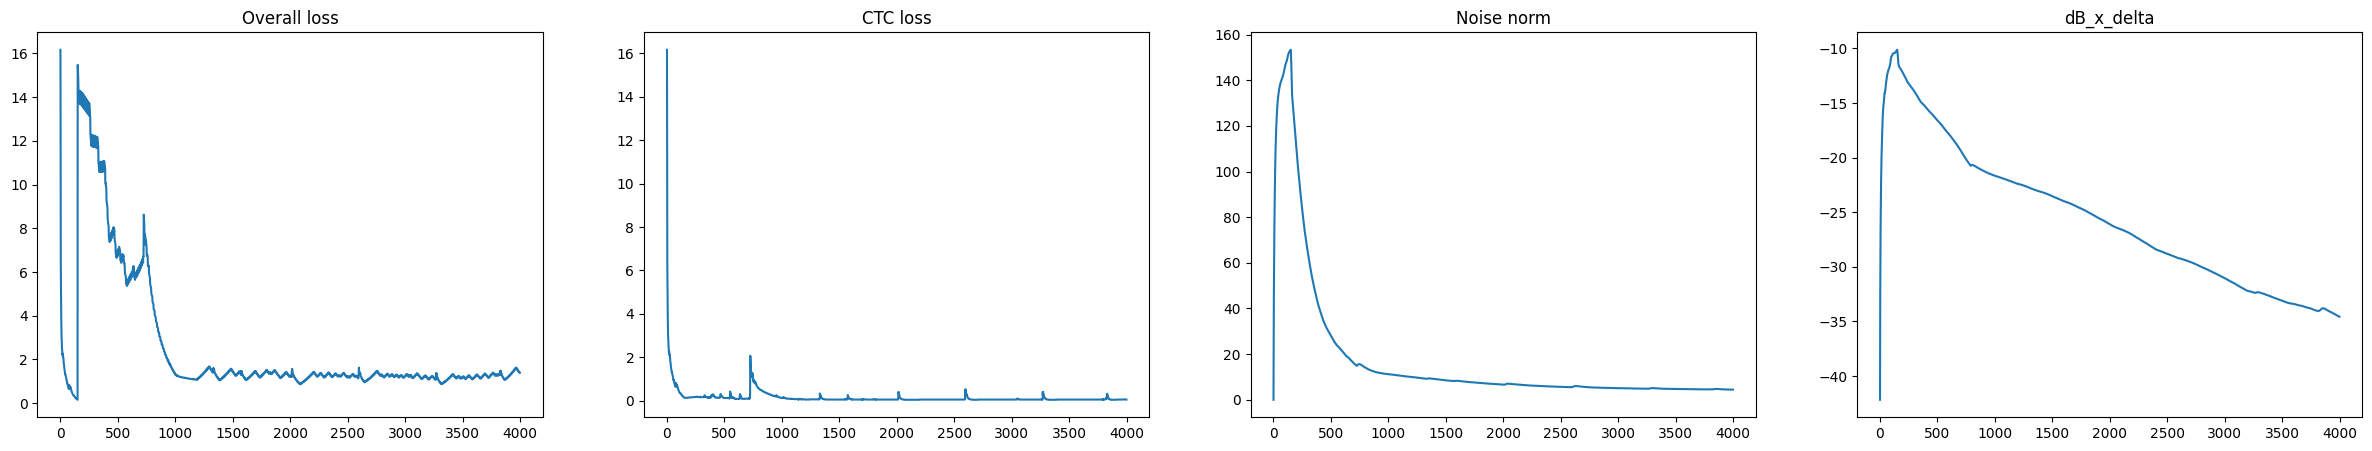

In [36]:
finalnoise, losses = attack(
    "STOP RIGHT THERE CRIMINAL SCUM YOU HAVE VIOLATED THE LAW PAY THE COURT A FINE OR SERVE YOUR SENTENCE",
    [model_base],
    [processor_base],
    samples[sampleid],
    rates[sampleid],
    "cuda",
    noise_norm_target=3.5
)
print()
print("Final prediction :")
finalnoise = finalnoise.detach()
attacked_audio = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_base, processor_base).cpu()
IPython.display.display(IPython.display.Audio(attacked_audio, rate=rates[sampleid]))
torchaudio.save(f"sample_{sampleid}_attack.wav", attacked_audio, rates[sampleid])
plotlosses(losses)

In [37]:
sampleid = 2
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_base, processor_base)
truetext[sampleid]

['I HAVE REMAINED A PRISONER ONLY BECAUSE I WISHED TO BE ONE AND WITH THIS HE STEPPED FORWARD AND BURST THE STOUT CHAINS AS EASILY AS IF THEY HAD BEEN THREADS']


'I HAVE REMAINED A PRISONER ONLY BECAUSE I WISHED TO BE ONE AND WITH THIS HE STEPPED FORWARD AND BURST THE STOUT CHAINS AS EASILY AS IF THEY HAD BEEN THREADS'


Iteration:  3990
  Overall loss:  0.0
  CTC loss:  0.0
  Noise norm:  139.69
  dB_x_delta:  -12.62
  dn_w: 0, ctc_weight: 1.0, lr: 0.05
  Current predictions:
    
!!!! MAX ITERATION REACHED, DIDN'T HIT TRESHOLD !!!!
Reverting to previous best noise...
Final noise norm: inf
Final dB: None
Sadly exiting...

Final prediction :
['']


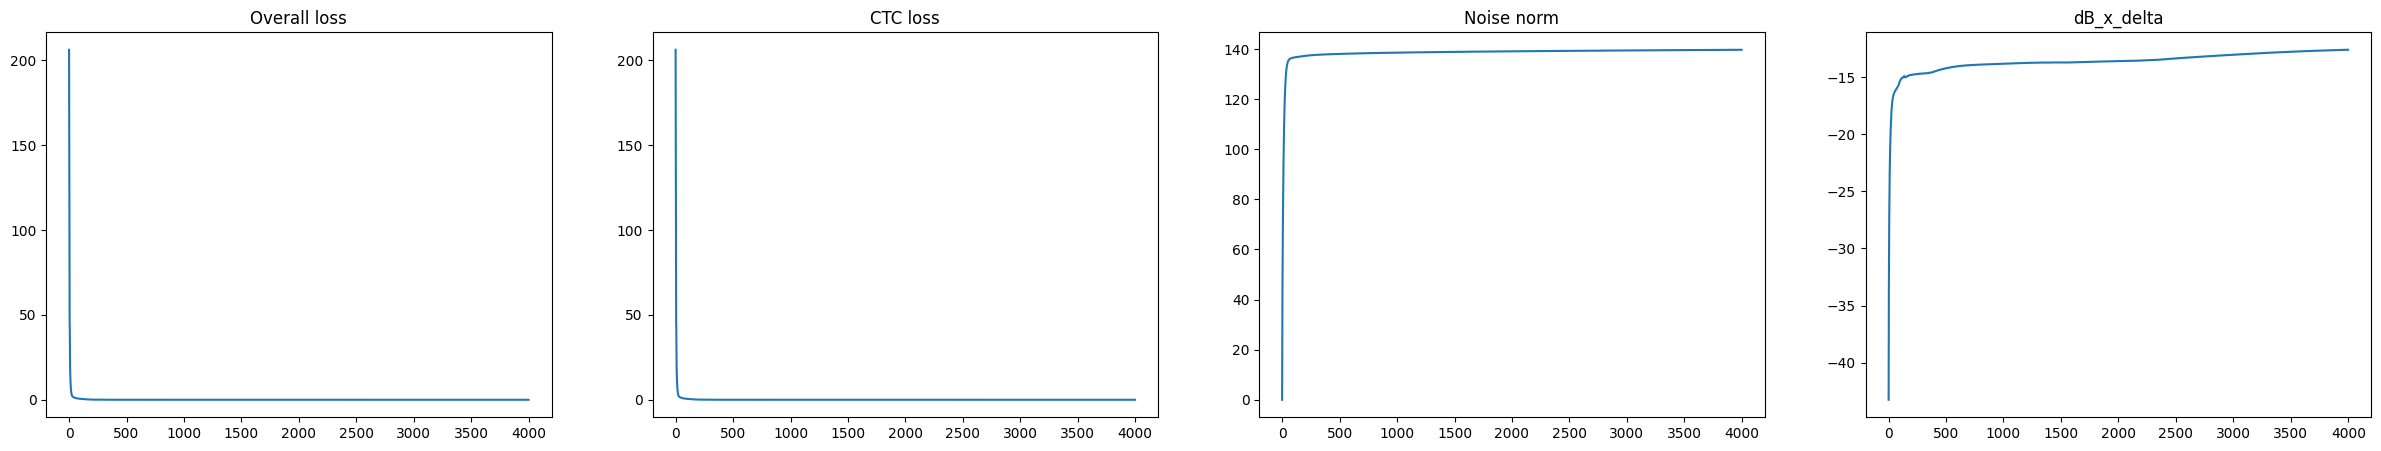

In [38]:
finalnoise, losses = attack(
    "         ",
    [model_base],
    [processor_base],
    samples[sampleid],
    rates[sampleid],
    "cuda",
    noise_norm_target=3.5
)
print()
print("Final prediction :")
finalnoise = finalnoise.detach()
attacked_audio = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_base, processor_base).cpu()
IPython.display.display(IPython.display.Audio(attacked_audio, rate=rates[sampleid]))
torchaudio.save(f"sample_{sampleid}_attack.wav", attacked_audio, rates[sampleid])
plotlosses(losses)

In [39]:
sampleid = 3
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_base, processor_base)
truetext[sampleid]

['THE LITTLE GIRL HAD BEEN ASLEEP BUT SHE HEARD THE RAPS AND OPENED THE DOOR']


'THE LITTLE GIRL HAD BEEN ASLEEP BUT SHE HEARD THE RAPS AND OPENED THE DOOR'


Iteration:  3140
  Overall loss:  2.24
  CTC loss:  0.09
  Noise norm:  3.49
  dB_x_delta:  -28.15
  dn_w: 0.6165323847328822, ctc_weight: 1.0, lr: 0.00010029051606985293
  Current predictions:
    MAMMA JUST KILLED A MAN PUT A GUN AGAINST HIS HEAD PULLED MY TRIGGER NOW HE DEAD
  !!!! DESIRED NOISE NORM REACHED !!!!
  Final noise norm: 3.4875333309173584
  Final dB: -28.154821395874023
  Happily exiting...

Final prediction :
['MAMMA JUST KILLED A MAN PUT A GUN AGAINST HIS HEAD PULLED MY TRIGGER NOW HE DEAD']


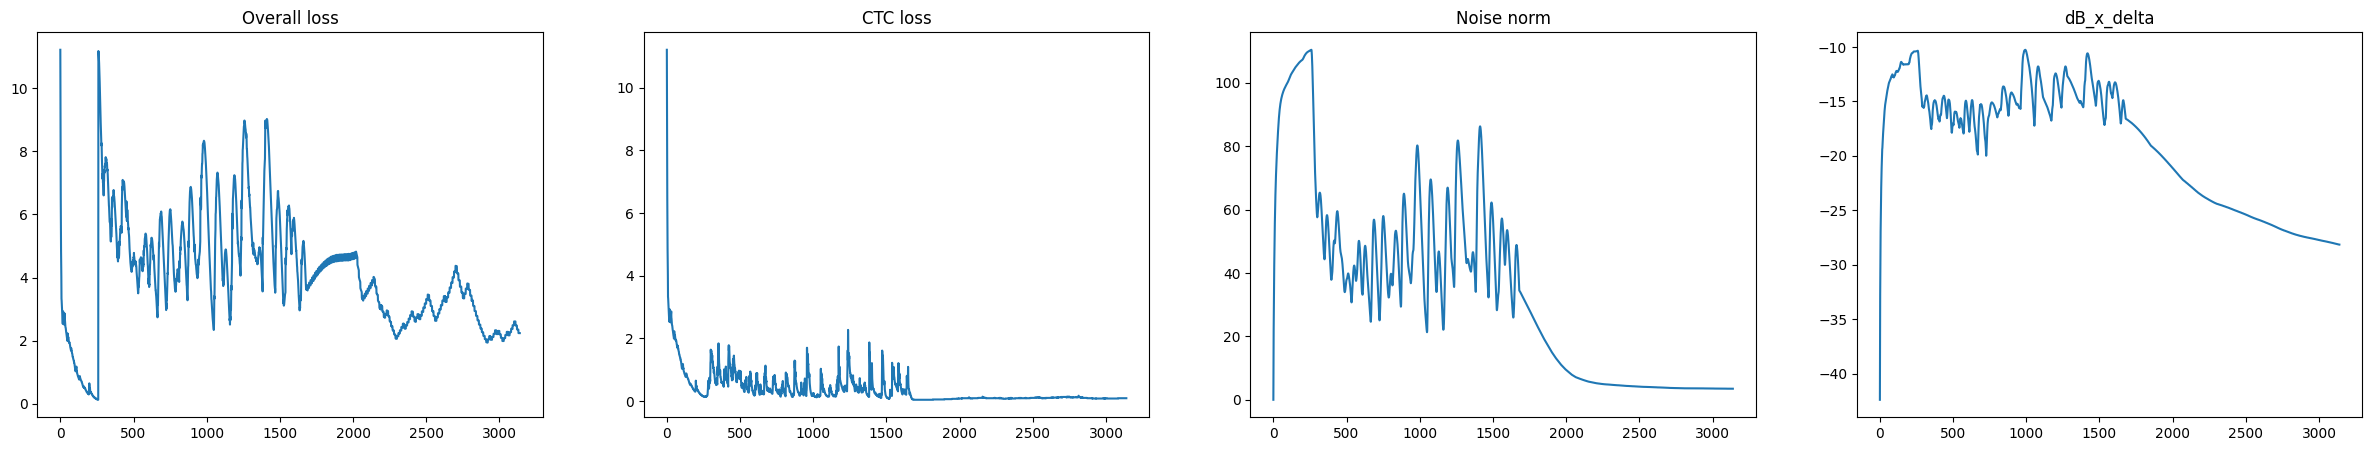

In [40]:
finalnoise, losses = attack(
    "MAMMA JUST KILLED A MAN PUT A GUN AGAINST HIS HEAD PULLED MY TRIGGER NOW HE DEAD",
    [model_base],
    [processor_base],
    samples[sampleid],
    rates[sampleid],
    "cuda",
    noise_norm_target=3.5
)
print()
print("Final prediction :")
finalnoise = finalnoise.detach()
attacked_audio = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_base, processor_base).cpu()
IPython.display.display(IPython.display.Audio(attacked_audio, rate=rates[sampleid]))
torchaudio.save(f"sample_{sampleid}_attack.wav", attacked_audio, rates[sampleid])
plotlosses(losses)

## Trying to generalize the attack: attacking two models at once

In [41]:
sampleid = 1
print("True text")
print(truetext[sampleid])
print("Initial base prediction")
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_base, processor_base)
print("Initial large prediction")
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_large, processor_large, "cpu")

True text
HE HAS GONE AND GONE FOR GOOD ANSWERED POLYCHROME WHO HAD MANAGED TO SQUEEZE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST
Initial base prediction
['HE HAS GONE AND GONE FOR GOOD ANSWERED POLYCHROME WHO HAD MANAGED TO SQUEEZE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST']
Initial large prediction
['HE HAS GONE AND GONE FOR GOOD ANSWERED POLYCHROME WHO HAD MANAGED TO SQUEEZE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST']


In [42]:
finalnoise, losses = attack(
    "HE IS SPEAKING THE LANGUAGE OF THE GODS",
    [model_base, model_large],
    [processor_base, processor_large],
    samples[sampleid],
    rates[sampleid],
    "cuda",
    noise_norm_target=5
)
print()
print("Final prediction on base:")
finalnoise = finalnoise.detach()
attacked_audio = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_base, processor_base).cpu()
print("Final prediction on large:")
attacked_audio = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_large, processor_large).cpu()
IPython.display.display(IPython.display.Audio(attacked_audio, rate=rates[sampleid]))
torchaudio.save("multimodel_attack.wav", attacked_audio, rates[sampleid])


Iteration:  3990
  Overall loss:  2.46
  CTC loss:  0.1
  Noise norm:  6.78
  dB_x_delta:  -28.99
  dn_w: 0.3479069614554263, ctc_weight: 1.0, lr: 0.00021614229542130797
  Current predictions:
    HE IS SPEAKING THE LANGUAGE OF THE GODS
    HE IS SPEAKING THE LANGUAGE OF THE GODS
!!!! MAX ITERATION REACHED, DIDN'T HIT TRESHOLD !!!!
Reverting to previous best noise...
Final noise norm: 6.754530429840088
Final dB: -28.81816864013672
Sadly exiting...

Final prediction on base:
['HE IS SPEAKING THE LANGUAGE OF THE GODS']
Final prediction on large:
['HE IS SPEAKING THE LANGUAGE OF THE GODS']


Does it generalize to a third wav2vec model?

In [43]:
model_test = Wav2Vec2ForCTC.from_pretrained("vasista22/wav2vec2-360h-base-ft-100h")
processor_test = Wav2Vec2Processor.from_pretrained("vasista22/wav2vec2-360h-base-ft-100h")

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


In [44]:
_ = evaluate(samples[sampleid], torch.zeros_like(torch.tensor(samples[sampleid])), rates[sampleid], model_test, processor_test, "cpu")

['HE HAS GONE AND GONE FOR GOOD ANSWERED POLIC CROM WHO HADMANAGED DISQUEESE INTO THE ROOM BESIDE THE DRAGON AND HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST']


In [45]:
_ = evaluate(samples[sampleid], finalnoise, rates[sampleid], model_test, processor_test, "cpu")

['HE HAS GONE AND GONE FOR GOOD ANTERED POLIC CROM WHO HADMANAGED DISGREECED INTO THE ROOM BESIDE THE DRAGON AN HAD WITNESSED THE OCCURRENCES WITH MUCH INTEREST']


No it doesn't :(

But we still managed to generate adversarial examples that work on two models at once, which is pretty cool! And maybe by optimizing the attack on more models at once, especially models with different architectures, we could get it to generalize.